In [1]:
import bt
import FinanceDataReader as fdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import seaborn as sns

# pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot') #ggplot
plt.rcParams['font.family'] = 'nanummyeongjo'
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.formatter.useoffset'] = False
# plt.rcParmas['axes.formatter.limits'] = -1000, 1000

plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from IPython.display import display, HTML
"%config InlineBackend.figure_format = 'retina'"

#하나의 cell에서 multiple output을 출력을 가능하게 하는 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Pandas Dataframe의 사이즈가 큰 경우, 어떻게 화면에 출력을 할지를 세팅하는 코드
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from strategy import*
from utils import *

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [4]:
prices = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)

In [5]:
def AMS(x):
    ''' x : Series (DataFrame의 컬럼)
        x[-1] : 기준일. x의 현재값
        (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
        => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
    '''
    # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
    return np.mean(np.where(x[-1]>x, 1, 0)[:-1]) # 당일 날짜 비교는 제외해준다 [:-1]    

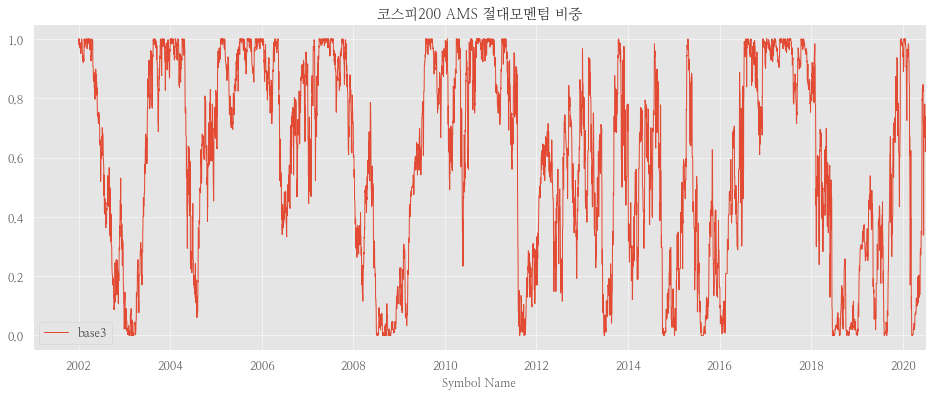

In [6]:
c='코스피200'
target_weights = pd.DataFrame()
target_weights['base3'] = prices[c].rolling(365).apply(AMS)
# %%
target_weights['현금'] = 1.0 - target_weights
target_weights.columns = ['base3', '현금']
target_weights['base3'].plot(figsize=(16,6), title='코스피200 AMS 절대모멘텀 비중', legend=True);

In [7]:
tickers = list(prices.columns[:-4])+['현금']

In [8]:
base3 = bt.Strategy(
    'base3',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(), bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0)),
        bt.algos.SelectN(n=3, sort_descending=True),
        # bt.algos.PrintDate(),
        bt.algos.WeighEqually(),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)
# %%
bt_id3 = bt.Backtest(base3, prices) 
r_id3 = bt.run(bt_id3)

In [9]:
kbase3 = bt.Strategy(
    'kbase3',
     [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=3, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)
# %%
bt_kbase3 = bt.Backtest(kbase3, prices) 
r = bt.run(bt_id3, bt_kbase3)

In [10]:
r.set_date_range("2002-02-01") 
r.display()

Stat                 base3       kbase3
-------------------  ----------  ----------
Start                2002-02-01  2002-02-01
End                  2020-07-02  2020-07-02
Risk-free rate       0.00%       0.00%

Total Return         884.07%     892.69%
Daily Sharpe         0.51        0.67
Daily Sortino        0.78        1.02
CAGR                 13.22%      13.27%
Max Drawdown         -60.86%     -37.79%
Calmar Ratio         0.22        0.35

MTD                  2.32%       1.51%
3m                   26.46%      6.02%
6m                   12.28%      2.67%
YTD                  11.70%      2.16%
1Y                   3.67%       -1.19%
3Y (ann.)            -6.31%      -2.27%
5Y (ann.)            0.03%       4.19%
10Y (ann.)           10.24%      8.99%
Since Incep. (ann.)  13.22%      13.27%

Daily Sharpe         0.51        0.67
Daily Sortino        0.78        1.02
Daily Mean (ann.)    10.90%      9.65%
Daily Vol (ann.)     21.58%      14.46%
Daily Skew           -0.19       -0.18
Da

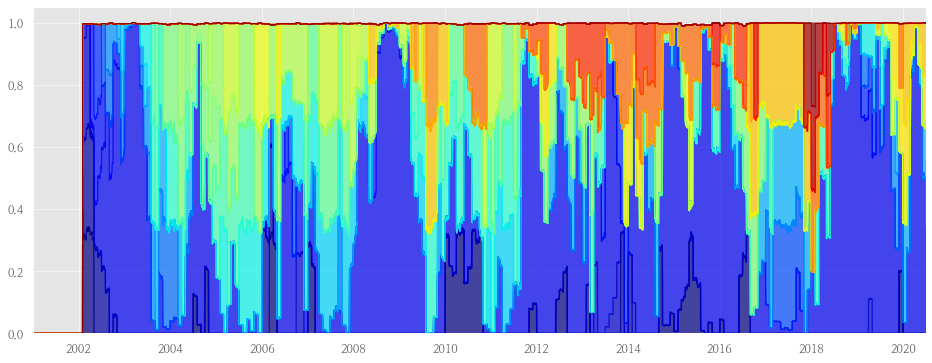

In [11]:
r.get_security_weights('kbase3').plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

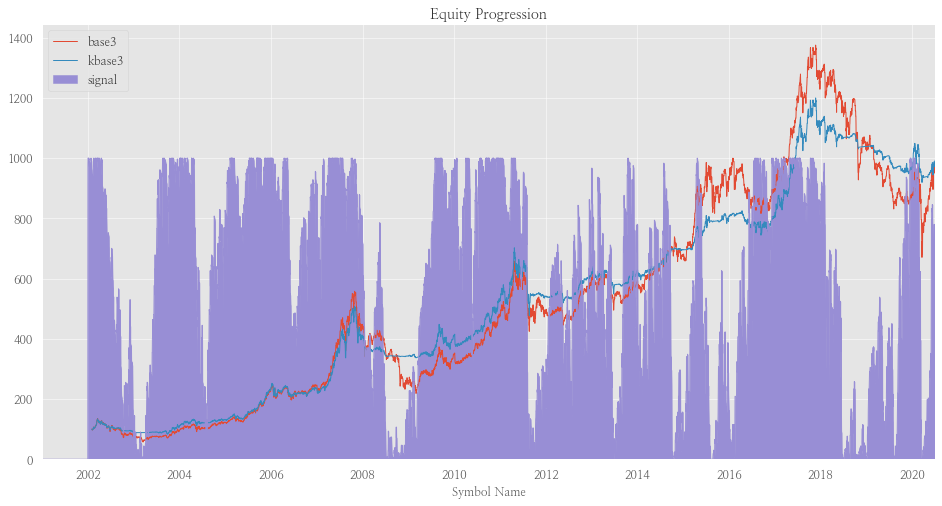

In [12]:
ax = r.plot(figsize=(16,8));
(target_weights['base3']*1000).plot.area(ax=ax, label='signal');
# (외국인수급['kospi']*10).plot(ax=ax, label='외국인수급');
plt.legend(loc="upper left");

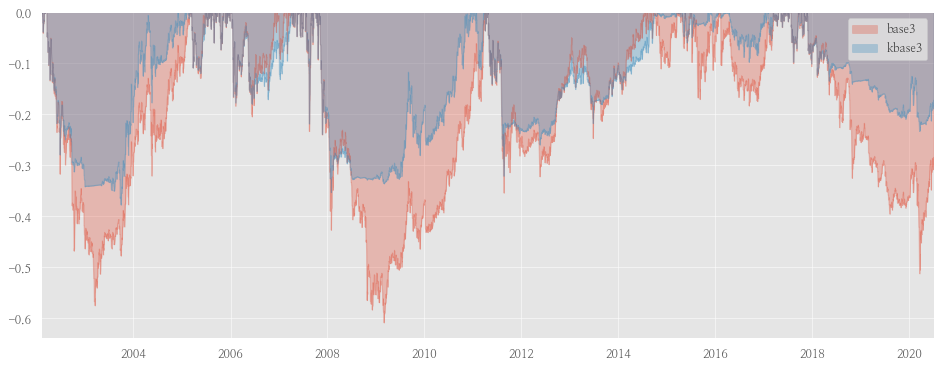

In [13]:
r.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

In [14]:
# bt_kbase3.positions.to_csv('한국ID2상대모멘텀_포지션.csv')